# Д/з #3

### Задача 1

Используя RandomForestClassifier и еще 2 метода МО предсказать будущий ABC класс на основе любых фичей

In [2]:
import pandas as pd
import numpy as np


filepath = '/Users/pavelzurkin/Desktop/DataSet_w_NA.xlsx'
df = pd.read_excel(filepath, sheet_name = 'Испорченные факты')
df = df.dropna() # минус пустые строки
df = pd.pivot_table(df, values = ['Продажи, руб', 'Продажи, шт','Повторение заказа','Маржинальная прибыль','Повторение товара'], index=["Факты.Товар ID"],
                     aggfunc = {'Продажи, шт': [np.median, np.sum], 'Продажи, руб': np.sum, 'Повторение заказа': np.sum, 'Маржинальная прибыль': np.sum})    
df.columns = df.columns.map('_'.join) # иии раз
#df = df.reset_index() # иии два
df['Доля'] = df['Продажи, руб_sum'] / df['Продажи, руб_sum'].sum() * 100
df = df.sort_values(by = ('Продажи, руб_sum'), ascending = False) # сортировочка
df = df.assign(sum_d = df['Доля'].cumsum())
 
df.loc[(df['sum_d'] <= 80), 'ABC'] = 'A'
df.loc[(df['sum_d'] > 80) & (df['sum_d'] <= 95), 'ABC'] = 'B'
df.loc[(df['sum_d'] > 95), 'ABC'] = 'C'
df

,Маржинальная прибыль_sum,Повторение заказа_sum,"Продажи, руб_sum","Продажи, шт_median","Продажи, шт_sum",Доля,sum_d,ABC
Факты.Товар ID,,,,,,,,
PROD0001406,1.259996e+07,17,30799912.0,4.0,20.0,2.681845,2.681845,A
PROD0000454,3.876520e+06,23,13726692.0,3.0,31.0,1.195226,3.877071,A
PROD0001430,-9.055392e+05,7,11319240.0,6.0,6.0,0.985602,4.862673,A
PROD0000488,1.746230e-10,15,10935288.0,5.0,39.0,0.952170,5.814843,A
PROD0001187,1.116753e+06,33,9911739.5,3.0,37.0,0.863046,6.677889,A
...,...,...,...,...,...,...,...,...
PROD0001871,1.578500e+03,1,3850.0,2.0,2.0,0.000335,99.999089,C
PROD0001887,1.193400e+03,1,3536.0,2.0,2.0,0.000308,99.999396,C
PROD0001779,1.555200e+03,3,3240.0,1.0,1.0,0.000282,99.999679,C


------------------------------------------------

И вычислим значения, необходимые для предсказания будущих классов ABC

In [3]:
df['Продажи в следующем периоде']= (df['Продажи, шт_sum'] + df['Продажи, шт_median']) * (df['Продажи, руб_sum'] / df['Продажи, шт_sum'])
df['Доля_будущая'] = df['Продажи в следующем периоде'] / df['Продажи в следующем периоде'].sum() * 100


----------------------

### RandomForestClassifier

In [6]:
from sklearn.ensemble import RandomForestClassifier


np.random.seed(0)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= 0.8 # будет ли строчка обучающей?
train, test = df[df['is_train'] == True], df[df['is_train'] == False] # разбиваем на обучающую и тестовую выборки
print(f'Кол-во обучающих данных: {len(train)}\nКол-во тестовых данных: {len(test)}')
features = df.columns[2:3] 
features = features.append(df.columns[5:6])
print(f'\nОбучение по фичам: "{features[0]}" и "{features[1]}"')
y = pd.factorize(train['ABC'])[0]

clf = RandomForestClassifier(n_jobs=2, random_state=0) # создаем классификатор Random Forest
clf.fit(train[features], y) # обучили модель!!!
clf.predict(test[features]) # предсказали для тестовой выборки

lst_signif = list(zip(train[features], clf.feature_importances_)) # значимость факторов
print(f'Значимость фичи: {lst_signif[0][1]}; {lst_signif[1][1]}')

# проверим насколько точно сработал метод 
print('\nConfusion matrix:')
pd.crosstab(test['ABC'], clf.predict(test[features]), rownames=['Настоящие знач.'], colnames=['Предсказанные знач.'])

Кол-во обучающих данных: 1461
Кол-во тестовых данных: 401

Обучение по фичам: "Продажи, руб_sum" и "Доля"
Значимость фичи: 0.5089608258159515; 0.49103917418404847

Confusion matrix:


Предсказанные знач.,0,1,2
Настоящие знач.,,,
A,77,0,0
B,0,103,0
C,0,0,221


-----------

Теперь необходимо предсказать будущие классы ABC на основе тех данных, что мы получили ранее ("Продажи в следующем периоде" и "Доля_будущая").

In [7]:
rfc_df = df[['Продажи в следующем периоде', 'Доля_будущая']]
print(f'\nПрогрноз по фичам: "{rfc_df.columns[0]}" и "{rfc_df.columns[1]}"')
rfc_df.columns.values[0] = 'Продажи, руб_sum'
rfc_df.columns.values[1] = 'Доля'
features = rfc_df.columns[:2] 
df = df.assign(ABC_RFC = clf.predict(rfc_df[features]))

df.loc[(df['ABC_RFC'] == 0), 'ABC_RFC'] = 'A'
df.loc[(df['ABC_RFC'] == 1), 'ABC_RFC'] = 'B'
df.loc[(df['ABC_RFC'] == 2), 'ABC_RFC'] = 'C'
df.loc[(df['ABC'] != df['ABC_RFC']), 'RFC_change'] = 1
df.loc[(df['ABC'] == df['ABC_RFC']), 'RFC_change'] = 0

print(f'Значений поменялось: {df["RFC_change"].sum()} (шт.)\n\nConfusion matrix:')
pd.crosstab(df['ABC'], df['ABC_RFC'], rownames=['Прошлые знач.'], colnames=['Предсказанные знач.'])


Прогрноз по фичам: "Продажи в следующем периоде" и "Доля_будущая"
Значений поменялось: 91.0 (шт.)

Confusion matrix:


Предсказанные знач.,A,B,C
Прошлые знач.,,,
A,413,0,0
B,55,420,14
C,0,22,938


-------

### K-Means Clustering

Центроиды:
[[3.35036230e+05 2.44020658e-02]
 [1.35569807e+07 9.87410630e-01]
 [3.46467505e+06 2.52346526e-01]]


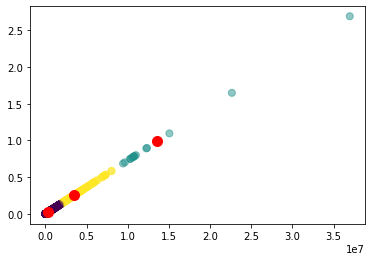

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


kmeans_df = df[['Продажи в следующем периоде', 'Доля_будущая']]
kmeans = KMeans(n_clusters=3).fit(kmeans_df)
centroids = kmeans.cluster_centers_
print(f'Центроиды:\n{centroids}')

df = df.assign(ABC_Kmeans = kmeans.labels_) # занесем классы в df
df.loc[(df['ABC_Kmeans'] == 2), 'ABC_Kmeans'] = 'B'
df.loc[(df['ABC_Kmeans'] == 1), 'ABC_Kmeans'] = 'A'
df.loc[(df['ABC_Kmeans'] == 0), 'ABC_Kmeans'] = 'C'
df.loc[(df['ABC'] != df['ABC_Kmeans']), 'Kmeans_change'] = 1
df.loc[(df['ABC'] == df['ABC_Kmeans']), 'Kmeans_change'] = 0

plt.scatter(df['Продажи в следующем периоде'], df['Доля_будущая'], c = kmeans.labels_.astype(float), s = 50, alpha = 0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c = 'red', s = 100)
plt.show()

------

In [15]:
print(f'Значений поменялось: {df["Kmeans_change"].sum()} (шт.)\n\nConfusion matrix:')
pd.crosstab(df['ABC'], df['ABC_Kmeans'], rownames=['Прошлые знач.'], colnames=['Предсказанные знач.'])

Значений поменялось: 887.0 (шт.)

Confusion matrix:


Предсказанные знач.,A,B,C
Прошлые знач.,,,
A,15,176,222
B,0,0,489
C,0,0,960


-----

### AdaBoost Classifier

In [16]:
from sklearn.ensemble import AdaBoostClassifier
import sklearn.model_selection as mod_s
from sklearn import metrics


df_input = df[['Продажи, руб_sum', 'Доля']] 
df_output = df['ABC']
print(f'\nОбучение по фичам: "{df_input.columns[0]}" и "{df_input.columns[1]}"')
x_train, x_test, y_train, y_test = mod_s.train_test_split(df_input, df_output, test_size = 0.2)
adaB_clas = AdaBoostClassifier(n_estimators = 50, learning_rate = 1) # создаем объект классификатора
adaB = adaB_clas.fit(x_train, y_train) # обучаем модель
y_pred = adaB.predict(x_test) # предсказываем
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
pd.crosstab(y_test, y_pred, rownames = ['Настоящие знач.'], colnames = ['Предсказанные знач.'])


Обучение по фичам: "Продажи, руб_sum" и "Доля"
Accuracy: 0.9973190348525469


Предсказанные знач.,A,B,C
Настоящие знач.,,,
A,73,0,0
B,0,102,0
C,0,1,197


-----

Теперь осталось предсказать будущие ABC классы по подготовленным ранее данным ("Продажи в следующем периоде" и "Доля_будущая").

In [19]:
adaB_df = df[['Продажи в следующем периоде', 'Доля_будущая']]
print(f'\nПрогрноз по фичам: "{adaB_df.columns[0]}" и "{adaB_df.columns[1]}"')
adaB_df.columns.values[0] = 'Продажи, руб_sum'
adaB_df.columns.values[1] = 'Доля'
features = adaB_df.columns[:2] 
df = df.assign(ABC_AdaBoost = adaB.predict(adaB_df[features]))

df.loc[(df['ABC'] != df['ABC_AdaBoost']), 'AdaBoost_change'] = 1
df.loc[(df['ABC'] == df['ABC_AdaBoost']), 'AdaBoost_change'] = 0

print(f'Значений поменялось: {df["AdaBoost_change"].sum()} (шт.)\n\nConfusion matrix:')
pd.crosstab(df['ABC'], df['ABC_AdaBoost'], rownames = ['Прошлые знач.'], colnames = ['Предсказанные знач.'])


Прогрноз по фичам: "Продажи в следующем периоде" и "Доля_будущая"
Значений поменялось: 90.0 (шт.)

Confusion matrix:


Предсказанные знач.,A,B,C
Прошлые знач.,,,
A,399,14,0
B,14,475,0
C,0,62,898


-----

### Заключение
После отработки всех методов МО предсказанные значения были занесены в основной Data Frame, а для большей наглядности выведем эти столбцы.

In [24]:
df[['ABC', 'ABC_RFC', 'ABC_AdaBoost', 'ABC_Kmeans', 'RFC_change', 'AdaBoost_change', 'Kmeans_change']]

,ABC,ABC_RFC,ABC_AdaBoost,ABC_Kmeans,RFC_change,AdaBoost_change,Kmeans_change
Факты.Товар ID,,,,,,,
PROD0001406,A,A,A,A,0.0,0.0,0.0
PROD0000454,A,A,A,A,0.0,0.0,0.0
PROD0001430,A,A,A,A,0.0,0.0,0.0
PROD0000488,A,A,A,A,0.0,0.0,0.0
PROD0001187,A,A,A,A,0.0,0.0,0.0
...,...,...,...,...,...,...,...
PROD0001871,C,C,C,C,0.0,0.0,0.0
PROD0001887,C,C,C,C,0.0,0.0,0.0
PROD0001779,C,C,C,C,0.0,0.0,0.0
